In [1]:
import torch
import torch
from torch_geometric.utils import dense_to_sparse
from torch_geometric.data import Data
import random
from torch_geometric.datasets.graph_generator import GraphGenerator, BAGraph
from torch_geometric.utils import barabasi_albert_graph
from tqdm.notebook import tqdm
import os
import pickle
from utils import draw_graph
from torch_geometric.utils import from_networkx

torch.manual_seed(7)
random.seed(7)

if not os.path.isdir("data"): os.mkdir("data")

In [2]:
def combine_data_objects(data1, data2, random_connect = True):
    # Concatenate node features
    combined_x = torch.cat([data1.x, data2.x], dim=0)

    # Offset the edge indices of the second graph to account for the new nodes
    data2_offset_edge_index = data2.edge_index + data1.num_nodes

    # Concatenate edge indices
    combined_edge_index = torch.cat([data1.edge_index, data2_offset_edge_index], dim=1)

    # Concatenate edge attributes if available
    if data1.edge_attr is not None and data2.edge_attr is not None:
        combined_edge_attr = torch.cat([data1.edge_attr, data2.edge_attr], dim=0)
    else:
        combined_edge_attr = None

    # Link Graphs TODO: Connect a random subset or something
    if random_connect and data1.num_nodes > 0 and data2.num_nodes > 0:
        node1 = random.choice(range(data1.num_nodes))
        node2 = random.choice(range(data1.num_nodes)) + data1.num_nodes
        # print(combined_edge_index.shape, torch.Tensor([[node1, node2]]).shape)
        combined_edge_index = torch.cat([combined_edge_index, torch.Tensor([[node1, node2]]).T],axis=1)

    # Create the combined Data object
    combined_data = Data(x=combined_x, edge_index=combined_edge_index.to(torch.int64), edge_attr=combined_edge_attr)
        

    return combined_data

In [3]:
class MotifGenerator(GraphGenerator):
    def __init__(self, num_nodes, num_edges, node_feature_dim, motifs):
        self.num_nodes = num_nodes
        self.num_edges = num_edges
        self.node_feature_dim = 5

        self.motifs = motifs

        for motif in self.motifs:
            assert motif.num_nodes < self.num_nodes - 1
            assert motif.num_features <= node_feature_dim 

    def __call__(self, motif_index = None) -> Data:
        if motif_index is None: motif_index = random.choice(range(len(self.motifs)))
        motif_graph = self.motifs[motif_index]

        ba_graph = Data(num_nodes=self.num_nodes-motif_graph.num_nodes, edge_index=barabasi_albert_graph(self.num_nodes-motif_graph.num_nodes, self.num_edges))
        ba_graph.x = torch.eye(self.node_feature_dim)[torch.randint(low=0,high=self.node_feature_dim,size=(ba_graph.num_nodes,))]
        
        combined_graph = combine_data_objects(ba_graph, motif_graph)
        combined_graph.y = motif_index
        return combined_graph

In [4]:
motif_0 = Data(x=torch.Tensor([]), edge_index=torch.empty((2,0)))
motif_1 = Data(x=torch.eye(5), edge_index=dense_to_sparse(torch.ones((5,5))-torch.eye(5))[0])
# motif_2 = Data(x=torch.eye(5), edge_index=dense_to_sparse(torch.ones((5,5)))[0])
motifs = [motif_0, motif_1]

g = MotifGenerator(num_nodes=10, num_edges=3, node_feature_dim=5, motifs=motifs)

In [5]:
data_list = [g(i % len(motifs)) for i in tqdm(range(1000))]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [6]:
if not os.path.isdir("data/OurMotifs"): os.mkdir("data/OurMotifs")
with open("data/OurMotifs/dataset.pkl", "wb") as f:
    pickle.dump(data_list, f)

In [7]:
data_list[0].x.dtype

torch.float32

In [8]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils.convert import to_networkx

def visualize_graph(data):
    # Convert PyG Data object to networkx graph
    G = to_networkx(data)

    # Create a plot and customize its appearance
    plt.figure(figsize=(8, 8))
    pos = nx.spring_layout(G, seed=42)
    nx.draw_networkx(G, pos, with_labels=True, node_color='skyblue', node_size=500, font_size=8, font_weight='bold', font_color='black')

    if data.edge_attr is not None:
        edge_labels = {(u, v): data.edge_attr[idx].item() for idx, (u, v) in enumerate(data.edge_index.T)}
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, font_color='red')

    plt.title(f"Graph Visualization: y={data.y}")
    plt.show()

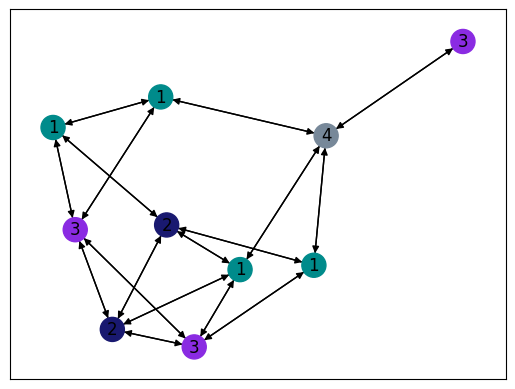

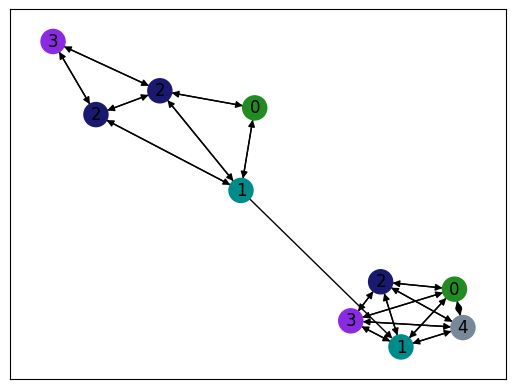

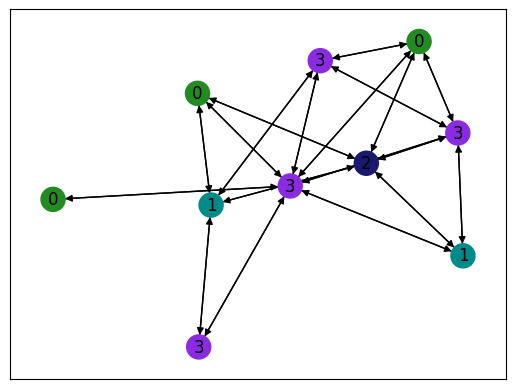

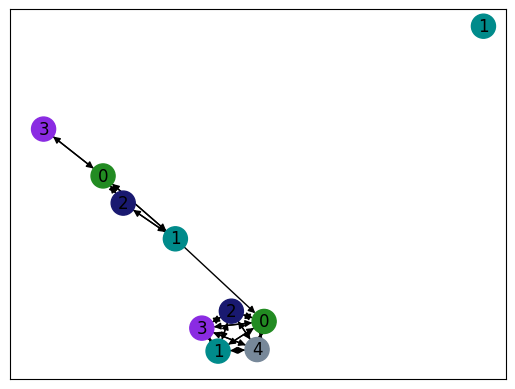

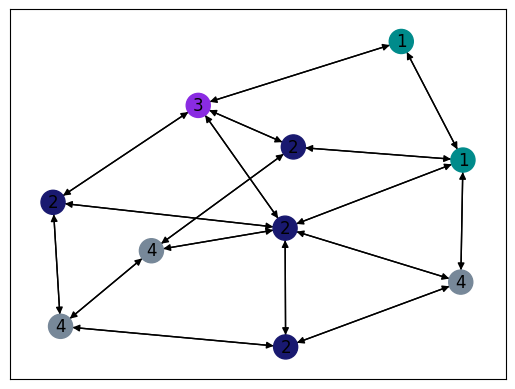

In [9]:
# # random.shuffle(data_list)

for g in data_list[:5]:
    draw_graph(data=g)



In [10]:
import torch
import torch
from torch_geometric.utils import dense_to_sparse
from torch_geometric.data import Data
import random
from torch_geometric.datasets.graph_generator import GraphGenerator, BAGraph
from torch_geometric.utils import barabasi_albert_graph
from tqdm.notebook import tqdm
import os
import pickle
from utils import draw_graph
from torch_geometric.utils import from_networkx

torch.manual_seed(7)
random.seed(7)

if not os.path.isdir("data"): os.mkdir("data")

In [11]:
import networkx as nx


datasets = []
labels = []
for i in range(2,9):
	for j in range(2,9):
		datasets.append(nx.grid_2d_graph(i, j))
		labels.append(0)
for i in range(3,65):
	datasets.append(nx.cycle_graph(i))
	labels.append(0)
	
for i in range(20):
	datasets.append(nx.cycle_graph(3))
	labels.append(0)

	
for i in range(2,65):
	datasets.append(nx.wheel_graph(i))
	labels.append(0)

for i in range(2,35):
	datasets.append(nx.circular_ladder_graph(i))
	labels.append(0)
				
		
for i in range(2,65):
	datasets.append(nx.star_graph(i))
	labels.append(1)


g= nx.balanced_tree(2, 5)
datasets.append(g)
labels.append(1)
for i in range(62, 2, -1):
	g.remove_node(i)
	datasets.append(g)
	labels.append(1)

for i in range(3,65):
	datasets.append(nx.path_graph(i))
	labels.append(1)
	

for i in range(3,5):
	for j in range(5,65):
		datasets.append(nx.full_rary_tree(i,j))
		labels.append(1)

normalize = False
Is_Acylic = []
for G, label in zip(datasets, labels):
	degree_dict = dict(G.degree())
	if normalize:
		max_degree = max(1, max(degree_dict.values()))
		degree_dict = {n: d/max_degree for n, d in degree_dict.items()}
	nx.set_node_attributes(G, degree_dict, 'degree')
	data = from_networkx(G, group_node_attrs=["degree"])
	data.x = data.x.to(torch.float32)
	data.y = label
	Is_Acylic.append(data)

if not os.path.isdir("data/Is_Acyclic"): os.mkdir("data/Is_Acyclic")
with open("data/Is_Acyclic/dataset.pkl", "wb") as f:
    pickle.dump(Is_Acylic, f)


In [12]:
Is_Acylic[0].x.dtype

torch.float32

In [13]:
# for data in Is_Acylic[:10]:
#     fig, ax = draw_graph(data = data)
#     plt.title(f"Class: {data.y}")

In [14]:
n = 8000
def add_random_edges(pair):
	G, label = pair
	nonedges = list(nx.non_edges(G))
	num_random_edges = min(round(G.number_of_edges()*(random.random()*0.2)), len(nonedges))
	added_nonedges = random.choices(nonedges, k=num_random_edges)
	G.add_edges_from(added_nonedges)
	return (G, label)
    
one_hot = torch.eye(5)
shapes = []
for _ in range(n):
	choice = random.choice(["Lollipop", "Wheel", "Grid", "Star", "Others"])
	if choice == "Lollipop":
		pair = (nx.lollipop_graph(n=random.randint(4,16), m=random.randint(4,16)), 0)
	elif choice == "Wheel":
		pair = (nx.wheel_graph(n=random.randint(4,64)), 1)
	elif choice == "Grid":
		pair = (nx.grid_2d_graph(n=random.randint(2,8), m=random.randint(2,8)), 2)
	elif choice == "Star":
		pair = (nx.star_graph(n=random.randint(4,64)), 3)
	elif choice == "Others":
		pair = (nx.binomial_graph(n=random.randint(8,32),p=(random.random()*0.8)+0.2), 4)
	# pair = add_random_edges(pair)
	shapes.append(pair)

normalize = False
Shapes = []
for G, label in shapes:
	degree_dict = dict(G.degree())
	if normalize:
		max_degree = max(1, max(degree_dict.values()))
		degree_dict = {n: d/max_degree for n, d in degree_dict.items()}
	nx.set_node_attributes(G, degree_dict, 'degree')
	data = from_networkx(G, group_node_attrs=["degree"])
	data.x = data.x.to(torch.float32)
	data.y = label
	Shapes.append(data)
      
if not os.path.isdir("data/Shapes_Clean"): os.mkdir("data/Shapes_Clean")
with open("data/Shapes_Clean/dataset.pkl", "wb") as f:
    pickle.dump(Shapes, f)

2


(<Figure size 640x480 with 1 Axes>, <Axes: >)

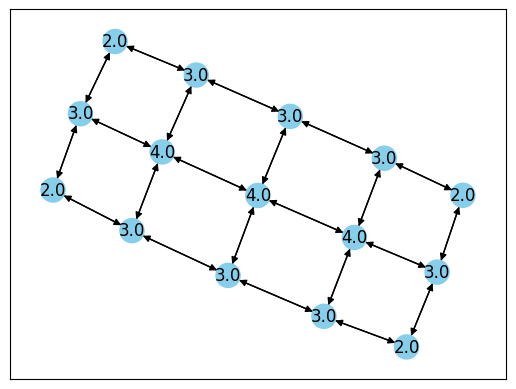

In [15]:
print(Shapes[0].y)
draw_graph(data = Shapes[0])

In [17]:
Shapes[0].x

tensor([[2.],
        [3.],
        [2.],
        [3.],
        [4.],
        [3.],
        [3.],
        [4.],
        [3.],
        [3.],
        [4.],
        [3.],
        [2.],
        [3.],
        [2.]])